In [1]:
import os 
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split

In [2]:
DATASET_DIR = './Dataset/train/audio/'
DATASET_DIR_TEST = './Dataset/train/audio/'

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [4]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind
    
df = pd.DataFrame(data_map.values(), 
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
# background = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
element_to_remove = "_background_noise_"
if element_to_remove in labels:
    labels.remove(element_to_remove)
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
#print(df_new["label_name"].value_counts())
df_new

,label_name,label,path
0,right,0,988e2f9a_nohash_0.wav
1,right,0,1eddce1d_nohash_3.wav
2,right,0,93ec8b84_nohash_0.wav
3,right,0,6272b231_nohash_1.wav
4,right,0,439c84f4_nohash_1.wav
...,...,...,...
64716,four,30,93f30cc4_nohash_1.wav
64717,four,30,0c40e715_nohash_0.wav
64718,four,30,238c112c_nohash_0.wav
64719,four,30,173ae793_nohash_1.wav


In [5]:
train_df, val_df = train_test_split(df_new, stratify=df_new['label'], test_size=0.1)
# train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
print(train_df.shape, val_df.shape)
print(train_df.dtypes)
print(train_df.head())

(58248, 3) (6473, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
60454        off     29  9ce7a419_nohash_1.wav
53830        yes     26  f34e6f44_nohash_2.wav
46291        two     22  8eb4a1bf_nohash_4.wav
32200        one     16  172dc2b0_nohash_0.wav
41449         up     20  837f7378_nohash_0.wav


In [6]:
def data_generator(df, num_classes, batch_size):
    while True:
        batch_images = []
        batch_labels = []
        for _ in range(batch_size):
            idx = np.random.randint(len(df))  # Randomly select an index
            row = df.iloc[idx]
            signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
            samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
            freqs, times, spectrogram = log_specgram(samples, sample_rate)
            img = cv2.resize(spectrogram, (32, 32))
            # Normalization
            img = (img - np.mean(img)) / np.std(img)
            img = np.stack((img,) * 3, axis=-1).astype(np.float32)
            label = np.zeros(num_classes)
            label[row['label']] = 1  # Setting the corresponding class index to 1
            batch_images.append(img)
            batch_labels.append(label)
        yield np.array(batch_images), np.array(batch_labels)

In [ ]:
def preprocess_data(row, num_classes):
    signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = np.divide((img - np.mean(img)),np.std(img),out=img, where=np.std(img)!=0)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.zeros(num_classes)
    label[row['label']] = 1
    return img, label

def create_dataset(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset

In [14]:
input_shape = (32, 32, 3)
num_classes = len(labels)
epochs = 2
batch_size = 64

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization

num_classes = num_classes

inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Transformer Block
num_heads = 8
ff_dim = 512
dropout_rate = 0.1

# Reshape for Transformer input
x = Reshape((-1, 128))(x)

# Multi-head self-attention
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=128 // num_heads)(x, x)
attention_output = Dropout(dropout_rate)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

# Feed-forward neural network
x = Dense(ff_dim, activation="relu")(attention_output)
x = Flatten()(x)  # Flatten the output for Dense layer

outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 15, 15,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 13,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 6, 6, 64)  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 2, 2, 128) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 512)       │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 128)    │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 128)    │     66,048 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 128)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 128)    │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4, 512)    │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2048)      │          0 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,600 (881.25 KB)

 Trainable params: 225,600 (881.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def preprocess_data(row, num_classes):
    signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = (img - np.mean(img)) / np.std(img)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.zeros(num_classes)
    label[row['label']] = 1
    return img, label

def create_dataset(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [13]:
train_dataset = create_dataset(train_df, num_classes, batch_size)
val_dataset = create_dataset(val_df, num_classes, batch_size)
model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 30), output.shape=(None, 2048)

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, accuracy_score

# y_true = []
# y_pred = []
# test_generator = data_generator(test_df, num_classes, batch_size)

# # Iterate over test data and collect true and predicted labels
# for i in range(len(test_df) // batch_size):
#     X_test_batch, y_test_batch = next(test_generator)
#     y_true.extend(np.argmax(y_test_batch, axis=1))  # True classes
#     y_pred.extend(np.argmax(model.predict(X_test_batch), axis=1))  # Predicted classes

In [8]:
# # Calculate accuracy
# accuracy = accuracy_score(y_true, y_pred)
# print("Accuracy:", accuracy)

# # Plot confusion matrix
# conf_mat = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_mat, cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

# # Set tick labels
# plt.xticks(np.arange(len(labels)), labels, rotation=90)
# plt.yticks(np.arange(len(labels)), labels, rotation=0)

In [13]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR_TEST)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR_TEST + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR_TEST + label
    data_map[ind] = label, os.listdir(data_path), ind
    
df = pd.DataFrame(data_map.values(), 
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
# background = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels_test.csv', index=True)
#print(df_new["label_name"].value_counts())
test_df = df_new
# test_dataset = create_dataset(test_df, num_classes, batch_size)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

y_true = []
y_pred = []
test_generator = data_generator(test_df, num_classes, batch_size)

# Iterate over test data and collect true and predicted labels
for i in range(len(test_df) // batch_size):
    X_test_batch, y_test_batch = next(test_generator)
    y_true.extend(np.argmax(y_test_batch, axis=1))  # True classes
    y_pred.extend(np.argmax(model.predict(X_test_batch), axis=1))  # Predicted classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━

Accuracy: 0.859297725024728


([<matplotlib.axis.YTick at 0x34d9d8690>,
 [Text(0, 0, 'right'),
  Text(0, 1, 'eight'),
  Text(0, 2, 'cat'),
  Text(0, 3, 'tree'),
  Text(0, 4, 'bed'),
  Text(0, 5, 'happy'),
  Text(0, 6, 'go'),
  Text(0, 7, 'dog'),
  Text(0, 8, 'no'),
  Text(0, 9, 'wow'),
  Text(0, 10, 'nine'),
  Text(0, 11, 'left'),
  Text(0, 12, 'stop'),
  Text(0, 13, 'three'),
  Text(0, 14, 'sheila'),
  Text(0, 15, 'one'),
  Text(0, 16, 'bird'),
  Text(0, 17, 'zero'),
  Text(0, 18, 'seven'),
  Text(0, 19, 'up'),
  Text(0, 20, 'marvin'),
  Text(0, 21, 'two'),
  Text(0, 22, 'house'),
  Text(0, 23, 'down'),
  Text(0, 24, 'six'),
  Text(0, 25, 'yes'),
  Text(0, 26, 'on'),
  Text(0, 27, 'five'),
  Text(0, 28, 'off'),
  Text(0, 29, 'four')])

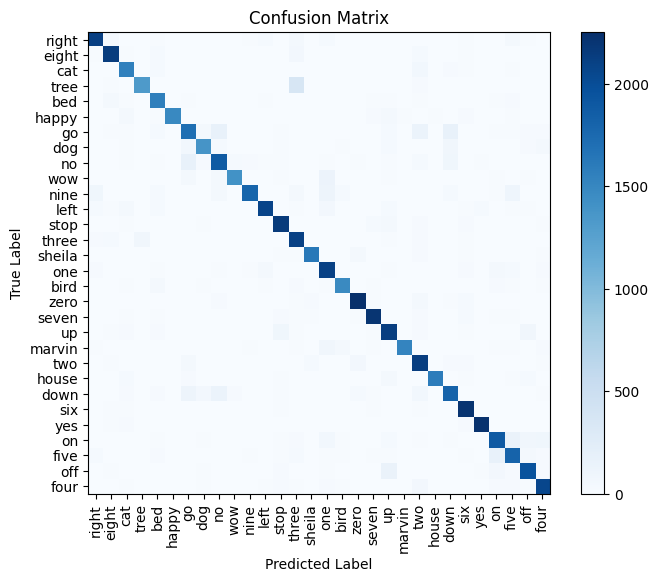

In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set tick labels
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels, rotation=0)